In [2]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

model.to(device)

_transform = Compose([
        ToTensor(),
        Normalize(image_processor.image_mean, image_processor.image_std),
    ])

def imgprocess_keepsize(img, patch_size=[16, 16], scale_factor=1):
    w, h = img.size
    ph, pw = patch_size
    nw = int(w * scale_factor / pw + 0.5) * pw
    nh = int(h * scale_factor / ph + 0.5) * ph

    ResizeOp = Resize((nh, nw), interpolation=InterpolationMode.BICUBIC)
    img = ResizeOp(img).convert("RGB")
    return _transform(img)

In [3]:
def forward_attention(attention_layer, x, head_mask=None, output_attentions=False):
    num_attention_heads = 1
    attention_head_size = 768 // num_attention_heads
    
    def transpose_for_scores(x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (num_attention_heads, attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)
        
    mixed_query_layer = attention_layer.query(x)

    key_layer = transpose_for_scores(attention_layer.key(x))
    value_layer = transpose_for_scores(attention_layer.value(x))
    query_layer = transpose_for_scores(mixed_query_layer)

    # Take the dot product between "query" and "key" to get the raw attention scores.
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

    attention_scores = attention_scores / math.sqrt(attention_layer.attention_head_size)

    # Normalize the attention scores to probabilities.
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)

    # This is actually dropping out entire tokens to attend to, which might
    # seem a bit unusual, but is taken from the original Transformer paper.
    attention_probs = attention_layer.dropout(attention_probs)

    # Mask heads if we want to
    if head_mask is not None:
        attention_probs = attention_probs * head_mask

    context_layer = torch.matmul(attention_probs, value_layer)

    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    new_context_layer_shape = context_layer.size()[:-2] + (attention_layer.all_head_size,)
    context_layer = context_layer.view(new_context_layer_shape)

    outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
    return outputs, (query_layer, key_layer, value_layer)


def vit_classifier(x):
    # modified from ViT
    batch_size, num_channels, height, width = x.shape
    print(height, width)

    ## keep image size 
    x = model.vit.embeddings(x, interpolate_pos_encoding=True)

    for i, layer_module in enumerate(model.vit.encoder.layer[:-1]):
        layer_outputs = layer_module(x, None, False)
        x = layer_outputs[0]
    

    ### the last layer in ViT
    lastLY = model.vit.encoder.layer[-1]

    x = lastLY.layernorm_before(x)

    attention_layer = lastLY.attention.attention
    self_outputs, (q,k,v) = forward_attention(attention_layer, x)
    attention_output = lastLY.attention.output(self_outputs[0], x)

    # residual connection
    x = attention_output + x

    # in ViT, layernorm is also applied after self-attention
    layer_output = lastLY.layernorm_after(x)
    layer_output = lastLY.intermediate(layer_output)

    # second residual connection is done here
    layer_output = lastLY.output(layer_output, x)
    sequence_output = model.vit.layernorm(layer_output)

    logits = model.classifier(sequence_output[:, 0, :])
    return logits, self_outputs[0], (q.detach(), k.detach(), v.detach()), (int(height//16), int(width//16))


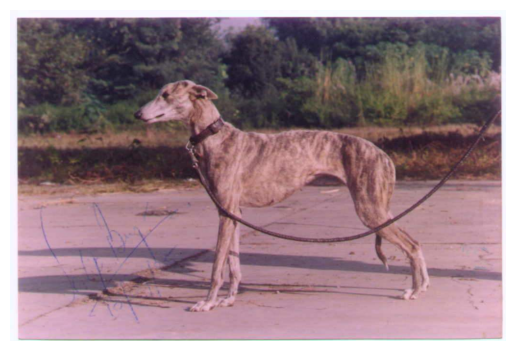

whippet


In [4]:
img_path = './whippet.png'

img = Image.open(img_path).convert("RGB")
inputs = image_processor(img, return_tensors="pt")['pixel_values']

plt.imshow(img)
plt.axis('off')
plt.show()

with torch.no_grad():
    logits = model(inputs.to(device)).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

In [5]:
def grad_eclip(c, q, k, v, att_output, map_size, withksim=True):
    D = k.shape[-1]
    ## gradient on last attention output
    grad = torch.autograd.grad(
        c,
        att_output,
        retain_graph=True)[0]
    grad = grad.detach()
    grad_cls = grad[0,:1,:]
    if withksim:
        q_cls = q[0,0,:1,:]
        k_patch = k[0,0,1:,:]
        q_cls = F.normalize(q_cls, dim=-1)
        k_patch = F.normalize(k_patch, dim=-1)
        cosine_qk = (q_cls * k_patch).sum(-1) 
        cosine_qk = (cosine_qk-cosine_qk.min()) / (cosine_qk.max()-cosine_qk.min())
        emap_lastv = F.relu_((grad_cls * v[0,0,1:,:] * cosine_qk[:,None]).detach().sum(-1)) # 
    else:
        emap_lastv = F.relu_((grad_cls * v[0,0,1:,:]).detach().sum(-1)) 
    return emap_lastv.reshape(*map_size)

def visualize(hmap, raw_image, resize):
    hmap -= hmap.min()
    hmap /= hmap.max()
    image = np.asarray(raw_image.copy())
    hmap = resize(hmap.unsqueeze(0))[0].cpu().numpy()
    color = cv2.applyColorMap((hmap*255).astype(np.uint8), cv2.COLORMAP_JET) # cv2 to plt
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    return c_ret

In [6]:
inputs = imgprocess_keepsize(img)
print(inputs.shape)
logits, last_att_outputs, (q, k, v), map_size = vit_classifier(inputs.unsqueeze(0).to(device))
print(logits.shape, logits.requires_grad, last_att_outputs.requires_grad, last_att_outputs.shape, q.shape, k.shape, v.shape)

torch.Size([3, 688, 1040])
688 1040
torch.Size([1, 1000]) True True torch.Size([1, 2796, 768]) torch.Size([1, 1, 2796, 768]) torch.Size([1, 1, 2796, 768]) torch.Size([1, 1, 2796, 768])


In [7]:
emap = grad_eclip(logits[:,predicted_label], q, k, v, last_att_outputs, map_size, withksim=True)

1032 689


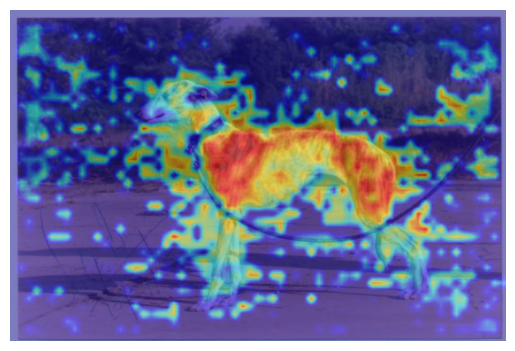

In [8]:
w, h = img.size
print(w,h)
resize = Resize((h,w))

c_ret = visualize(emap, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()